In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import time
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

seed=123456789
quantile=0.95
n_trees=100

def timming(since):
    time_elapsed=time.time()-since
    minutes=time_elapsed//60
    seconds=time_elapsed%60
    return "%d m: %d s"%(minutes,seconds)

In [35]:
data=pd.read_csv("HR_data_clusters.csv",index_col=0)
data.head()

,Employee_Name,EmpID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,Position,State,Zip,DOB,...,StateID,Age,SexID,MaritalDescID,CitizenDescID,HispanicLatinoID,RaceDescID,YearsHired,YearsTerminated,cluster
0,"Adinolfi, Wilson K",10026,4,0,62506,0,Production Technician I,MA,1960,07/10/83,...,16,39,0,1,2,1,5,11,0,2
1,"Ait Sidi, Karthikeyan",10084,3,0,104437,1,Sr. DBA,MA,2148,05/05/75,...,16,47,0,0,2,1,5,7,6,0
2,"Akinkuolie, Sarah",10196,3,0,64955,1,Production Technician II,MA,1810,09/19/88,...,16,34,1,0,2,1,5,11,10,0
3,"Alagbe,Trina",10088,3,0,64991,0,Production Technician I,MA,1886,09/27/88,...,16,34,1,0,2,1,5,14,0,0
4,"Anderson, Carol",10069,3,0,50825,1,Production Technician I,MA,2169,09/08/89,...,16,33,1,2,2,1,5,11,6,4


In [36]:
all_columns=data.columns
#demo_columns=["Salary","EngagementSurvey","EmpSatisfaction","SpecialProjectsCount","DaysLateLast30","Absences", 
#              "PerformanceScore","StateID","Age","SexID","MaritalDescID","CitizenDescID","HispanicLatinoID","RaceDescID",
#              "YearsHired","YearsTerminated"]

demo_columns=["StateID","Age","SexID","MaritalDescID","CitizenDescID","HispanicLatinoID","RaceDescID",
              "YearsHired","YearsTerminated"]

anomaly_columns=["Salary","EngagementSurvey","EmpSatisfaction","SpecialProjectsCount","DaysLateLast30","Absences", 
                 "PerfScoreID","cluster"]

In [37]:
print(all_columns)

Index(['Employee_Name', 'EmpID', 'PerfScoreID', 'FromDiversityJobFairID',
       'Salary', 'Termd', 'Position', 'State', 'Zip', 'DOB', 'Sex',
       'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore',
       'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount',
       'LastPerformanceReview_Date', 'DaysLateLast30', 'Absences', 'StateID',
       'Age', 'SexID', 'MaritalDescID', 'CitizenDescID', 'HispanicLatinoID',
       'RaceDescID', 'YearsHired', 'YearsTerminated', 'cluster'],
      dtype='object')


In [38]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on the following variables (together): 
#Salary, EngagementSurvey, EmpSatisfaction, SpecialProjectsCount, DaysLateLast30, Absences, PerfScoreID
############################
anomaly_data=pd.DataFrame(data,columns=anomaly_columns)
anomaly_data.iloc[:16]

,Salary,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,PerfScoreID,cluster
0,62506,4.60,5,0,0,1,4,2
1,104437,4.96,3,6,0,17,3,0
2,64955,3.02,3,0,0,3,3,0
3,64991,4.84,5,0,0,15,3,0
4,50825,5.00,4,0,0,2,3,4
5,57568,5.00,5,0,0,15,4,2
6,95660,3.04,3,4,0,19,3,2
7,59365,5.00,4,0,0,19,3,2
8,47837,4.46,3,0,0,4,3,6
9,50178,5.00,5,6,0,16,3,0


In [39]:
all_clusters=list(set(data["cluster"]))
n_clusters=len(all_clusters)
anomaly_employees=[]
anomaly_idx=[]
printing_iter=10**(0)
counter=0
since=time.time()

for cluster in all_clusters:
    temp=anomaly_data[anomaly_data["cluster"]==cluster]
    temp=temp.drop(["cluster"],axis=1)
    if_model=IsolationForest(random_state=seed,contamination=1-quantile,n_estimators=n_trees,max_samples="auto")
    if_fit=if_model.fit(temp)
    if_pred=if_model.predict(temp)
    temp["predictions"]=list(map(lambda x: 1*(x==-1),if_pred))
    idx=[i for i,x in enumerate(temp["predictions"]) if x==1]
    anomaly_employees.extend(data["Employee_Name"].iloc[idx])
    anomaly_idx.extend(idx)
    counter+=1
    if counter%printing_iter==0:
        print("Completion: %.4f%% \t time: %s"%(100*counter/n_clusters,timming(since)))

Completion: 14.2857% 	 time: 0 m: 0 s
Completion: 28.5714% 	 time: 0 m: 0 s
Completion: 42.8571% 	 time: 0 m: 0 s
Completion: 57.1429% 	 time: 0 m: 0 s
Completion: 71.4286% 	 time: 0 m: 0 s
Completion: 85.7143% 	 time: 0 m: 0 s
Completion: 100.0000% 	 time: 0 m: 0 s


In [40]:
anomaly_employees=list(set(anomaly_employees))
anomaly_idx=list(set(anomaly_idx))
print(anomaly_employees)
print(anomaly_idx)

['Buccheri, Joseph  ', 'Billis, Helen', 'Brill, Donna', 'Akinkuolie, Sarah', 'DeGweck,  James', 'Beatrice, Courtney ', 'Boutwell, Bonalyn', 'Cady, Max ', 'Alagbe,Trina', 'Andreola, Colby', 'Brown, Mia', 'Clukey, Elijian', 'Barbara, Thomas', 'Bates, Norman', 'Chigurh, Anton', 'Champaigne, Brian', 'Bacong, Alejandro ']
[65, 2, 35, 3, 6, 9, 42, 11, 45, 15, 17, 51, 22, 26, 28, 29, 30]


In [41]:
anomaly_employees_data=data.iloc[anomaly_idx]
anomaly_employees_data

,Employee_Name,EmpID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,Position,State,Zip,DOB,...,StateID,Age,SexID,MaritalDescID,CitizenDescID,HispanicLatinoID,RaceDescID,YearsHired,YearsTerminated,cluster
65,"DeGweck, James",10070,3,0,55722,1,Production Technician I,MA,1810,10/31/77,...,16,45,0,0,2,1,5,11,6,0
2,"Akinkuolie, Sarah",10196,3,0,64955,1,Production Technician II,MA,1810,09/19/88,...,16,34,1,0,2,1,5,11,10,0
35,"Cady, Max",10150,3,0,77692,0,Software Engineering Manager,MA,2184,11/22/66,...,16,56,0,1,2,1,5,11,0,0
3,"Alagbe,Trina",10088,3,0,64991,0,Production Technician I,MA,1886,09/27/88,...,16,34,1,0,2,1,5,14,0,0
6,"Andreola, Colby",10194,3,0,95660,0,Software Engineer,MA,2110,05/24/79,...,16,43,1,1,2,1,5,8,0,2
9,"Bacong, Alejandro",10250,3,0,50178,0,IT Support,MA,1886,01/07/88,...,16,34,0,2,2,1,5,7,0,0
42,"Champaigne, Brian",10108,3,0,110929,0,BI Director,MA,2045,02/09/72,...,16,50,0,0,2,1,5,6,0,0
11,"Barbara, Thomas",10242,3,1,47211,1,Production Technician I,MA,2062,02/21/74,...,16,48,0,0,2,0,4,10,6,1
45,"Chigurh, Anton",10200,3,0,66808,0,Area Sales Manager,TX,78207,06/11/70,...,7,52,0,1,1,1,4,10,0,1
15,"Bates, Norman",10061,3,0,57834,1,Production Technician I,MA,2050,10/18/81,...,16,41,0,1,2,1,5,11,5,0


In [42]:
anomaly_employees_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster
65,"DeGweck, James",55722,No,White,Webster Butler,Fully Meets,5.00,4,0,0,14,0
2,"Akinkuolie, Sarah",64955,No,White,Kissy Sullivan,Fully Meets,3.02,3,0,0,3,0
35,"Cady, Max",77692,No,White,Jennifer Zamora,Fully Meets,3.84,3,5,0,4,0
3,"Alagbe,Trina",64991,No,White,Elijiah Gray,Fully Meets,4.84,5,0,0,15,0
6,"Andreola, Colby",95660,No,White,Alex Sweetwater,Fully Meets,3.04,3,4,0,19,2
9,"Bacong, Alejandro",50178,No,White,Peter Monroe,Fully Meets,5.00,5,6,0,16,0
42,"Champaigne, Brian",110929,No,White,Jennifer Zamora,Fully Meets,4.50,5,7,0,8,0
11,"Barbara, Thomas",47211,Yes,Black or African American,Kissy Sullivan,Fully Meets,4.20,3,0,0,15,1
45,"Chigurh, Anton",66808,No,Black or African American,Lynn Daneault,Fully Meets,3.00,5,0,0,17,1
15,"Bates, Norman",57834,No,White,Kelley Spirea,Fully Meets,5.00,4,0,0,20,0


In [43]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on each of the following variables: 
#Salary, EngagementSurvey, EmpSatisfaction, SpecialProjectsCount, DaysLateLast30, Absences, PerfScoreID
############################
anomaly_columns=["Employee_Name","Salary","EngagementSurvey","EmpSatisfaction","SpecialProjectsCount","DaysLateLast30","Absences", 
                 "PerfScoreID","cluster"]

anomaly_data=pd.DataFrame(data,columns=anomaly_columns)
anomaly_data.head()

,Employee_Name,Salary,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,PerfScoreID,cluster
0,"Adinolfi, Wilson K",62506,4.60,5,0,0,1,4,2
1,"Ait Sidi, Karthikeyan",104437,4.96,3,6,0,17,3,0
2,"Akinkuolie, Sarah",64955,3.02,3,0,0,3,3,0
3,"Alagbe,Trina",64991,4.84,5,0,0,15,3,0
4,"Anderson, Carol",50825,5.00,4,0,0,2,3,4


array([[<AxesSubplot:title={'center':'Salary'}>]], dtype=object)

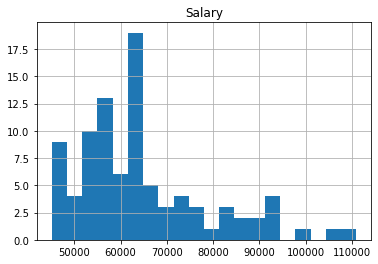

In [44]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on Salary.
############################
anomaly_data[anomaly_data["cluster"]==0][["Salary"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

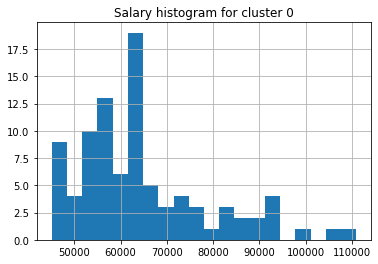

<Figure size 432x288 with 0 Axes>

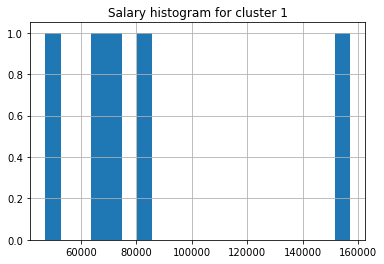

<Figure size 432x288 with 0 Axes>

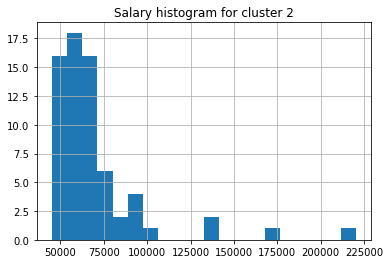

<Figure size 432x288 with 0 Axes>

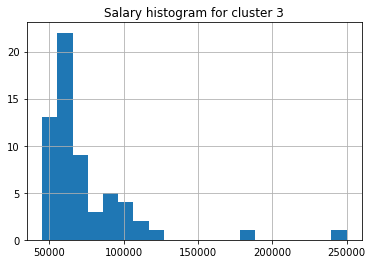

<Figure size 432x288 with 0 Axes>

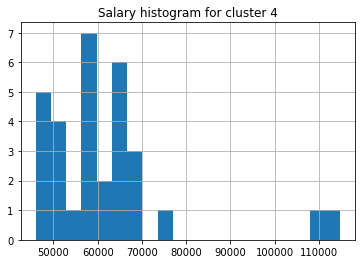

<Figure size 432x288 with 0 Axes>

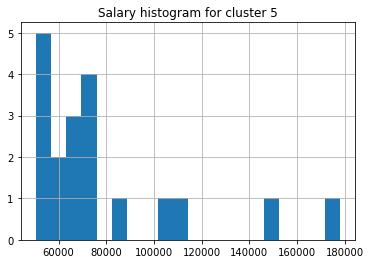

<Figure size 432x288 with 0 Axes>

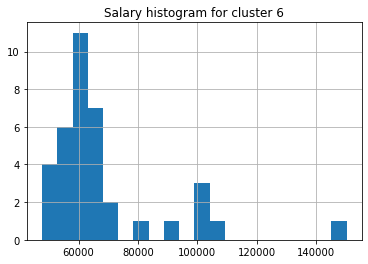

In [45]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["Salary"]].hist(bins=20)
    plt.title("Salary histogram for cluster %d"%(cluster))
    plt.show()

In [46]:
high_salary_employees=[]
low_salary_employees=[]
high_salary_employees_idx=[]
low_salary_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    salaries=anomaly_data[anomaly_data["cluster"]==cluster][["Salary"]]
    mean_salary=np.mean(salaries)
    sd_salary=np.std(salaries)
    z=(salaries-mean_salary)/sd_salary
    z=z["Salary"]
    high_salary_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_salary_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_salary_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_salary_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])

high_salary_employees=list(set(high_salary_employees))
high_salary_employees_idx=list(set(high_salary_employees_idx))
low_salary_employees=list(set(low_salary_employees))
low_salary_employees_idx=list(set(low_salary_employees_idx))
print(high_salary_employees)
print(high_salary_employees_idx)
print(low_salary_employees)
print(low_salary_employees_idx)

['Biden, Lowan  M', 'Akinkuolie, Sarah', 'Beatrice, Courtney ', 'Brown, Mia', 'Baczenski, Rachael  ', 'Adinolfi, Wilson  K', 'DeGweck,  James', 'Anderson, Linda  ']
[0, 65, 2, 5, 10, 17, 21, 29]
[]
[]


In [47]:
anomaly_employees_high_salary_data=data.iloc[high_salary_employees_idx]
anomaly_employees_high_salary_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster
0,"Adinolfi, Wilson K",62506,No,White,Michael Albert,Exceeds,4.60,5,0,0,1,2
65,"DeGweck, James",55722,No,White,Webster Butler,Fully Meets,5.00,4,0,0,14,0
2,"Akinkuolie, Sarah",64955,No,White,Kissy Sullivan,Fully Meets,3.02,3,0,0,3,0
5,"Anderson, Linda",57568,No,White,Amy Dunn,Exceeds,5.00,5,0,0,15,2
10,"Baczenski, Rachael",54670,Yes,Black or African American,David Stanley,Fully Meets,4.20,4,0,0,12,0
17,"Beatrice, Courtney",59026,No,White,Elijiah Gray,Fully Meets,5.00,5,0,0,12,4
21,"Biden, Lowan M",64919,No,Asian,Ketsia Liebig,Fully Meets,4.20,3,0,0,2,6
29,"Brown, Mia",63000,No,Black or African American,Brandon R. LeBlanc,Fully Meets,4.50,2,6,0,14,6


In [48]:
anomaly_employees_low_salary_data=data.iloc[low_salary_employees_idx]
anomaly_employees_low_salary_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


array([[<AxesSubplot:title={'center':'EngagementSurvey'}>]], dtype=object)

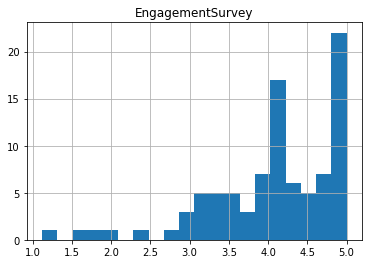

In [49]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on EngagementSurvey (whatever that is).
############################
anomaly_data[anomaly_data["cluster"]==0][["EngagementSurvey"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

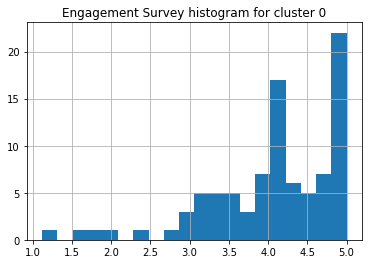

<Figure size 432x288 with 0 Axes>

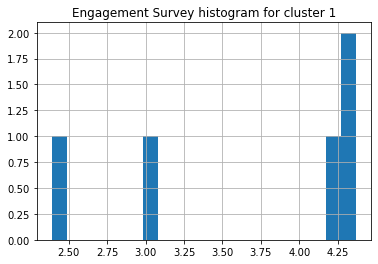

<Figure size 432x288 with 0 Axes>

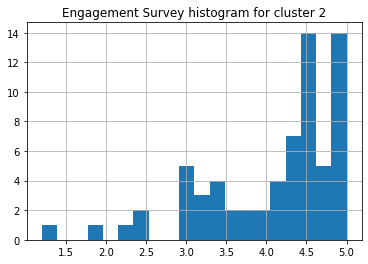

<Figure size 432x288 with 0 Axes>

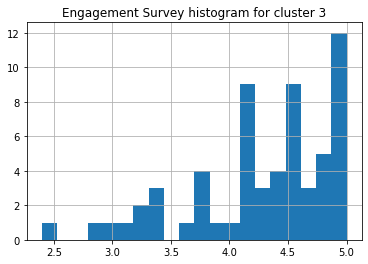

<Figure size 432x288 with 0 Axes>

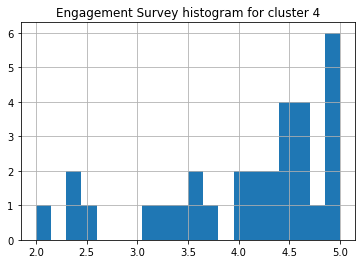

<Figure size 432x288 with 0 Axes>

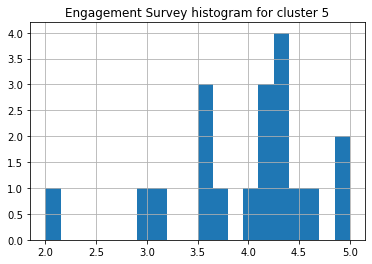

<Figure size 432x288 with 0 Axes>

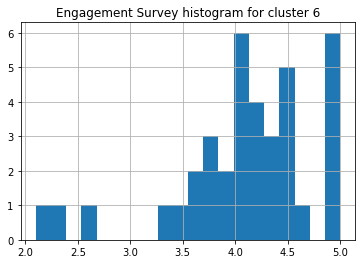

In [50]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["EngagementSurvey"]].hist(bins=20)
    plt.title("Engagement Survey histogram for cluster %d"%(cluster))
    plt.show()

In [51]:
high_eng_survey_employees=[]
low_eng_survey_employees=[]
high_eng_survey_employees_idx=[]
low_eng_survey_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    surveys=anomaly_data[anomaly_data["cluster"]==cluster][["EngagementSurvey"]]
    mean_survey=np.mean(surveys)
    sd_survey=np.std(surveys)
    z=(surveys-mean_survey)/sd_survey
    z=z["EngagementSurvey"]
    high_eng_survey_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_eng_survey_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_eng_survey_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_eng_survey_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])

high_eng_survey_employees=list(set(high_eng_survey_employees))
high_eng_survey_employees_idx=list(set(high_eng_survey_employees_idx))
low_eng_survey_employees=list(set(low_eng_survey_employees))
low_eng_survey_employees_idx=list(set(low_eng_survey_employees_idx))

print(high_eng_survey_employees)
print(high_eng_survey_employees_idx)
print(low_eng_survey_employees)
print(low_eng_survey_employees_idx)

[]
[]
['Billis, Helen', 'Brill, Donna', 'Dougall, Eric', 'Beatrice, Courtney ', 'Alagbe,Trina', 'Bernstein, Sean', 'Clukey, Elijian', 'Barbara, Thomas', 'Bacong, Alejandro ']
[3, 9, 11, 76, 17, 51, 20, 22, 28]


In [52]:
anomaly_employees_high_eng_survey_data=data.iloc[high_eng_survey_employees_idx]
anomaly_employees_high_eng_survey_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


In [53]:
anomaly_employees_low_eng_survey_data=data.iloc[low_eng_survey_employees_idx]
anomaly_employees_low_eng_survey_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster
3,"Alagbe,Trina",64991,No,White,Elijiah Gray,Fully Meets,4.84,5,0,0,15,0
9,"Bacong, Alejandro",50178,No,White,Peter Monroe,Fully Meets,5.00,5,6,0,16,0
11,"Barbara, Thomas",47211,Yes,Black or African American,Kissy Sullivan,Fully Meets,4.20,3,0,0,15,1
76,"Dougall, Eric",138888,No,Black or African American,Jennifer Zamora,Exceeds,4.30,5,5,0,4,2
17,"Beatrice, Courtney",59026,No,White,Elijiah Gray,Fully Meets,5.00,5,0,0,12,4
51,"Clukey, Elijian",50373,No,White,Brannon Miller,Exceeds,4.10,4,0,0,5,0
20,"Bernstein, Sean",51044,Yes,White,Amy Dunn,Fully Meets,5.00,3,0,0,13,2
22,"Billis, Helen",62910,No,White,Brannon Miller,Exceeds,5.00,3,0,0,19,3
28,"Brill, Donna",53492,No,White,David Stanley,Fully Meets,3.35,4,0,0,6,3


array([[<AxesSubplot:title={'center':'EmpSatisfaction'}>]], dtype=object)

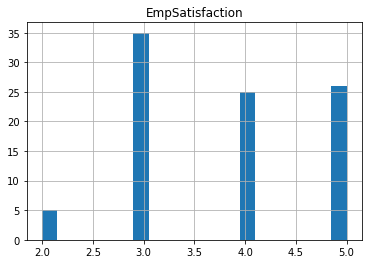

In [54]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on EmpSatisfaction.
############################
anomaly_data[anomaly_data["cluster"]==0][["EmpSatisfaction"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

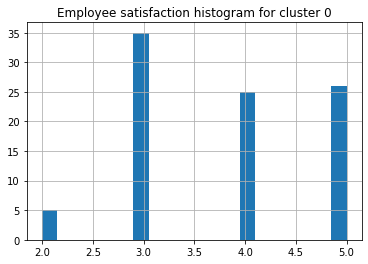

<Figure size 432x288 with 0 Axes>

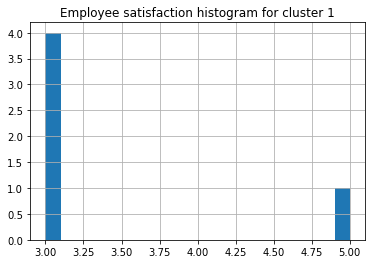

<Figure size 432x288 with 0 Axes>

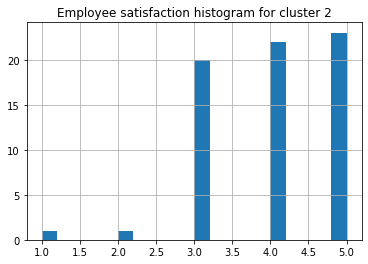

<Figure size 432x288 with 0 Axes>

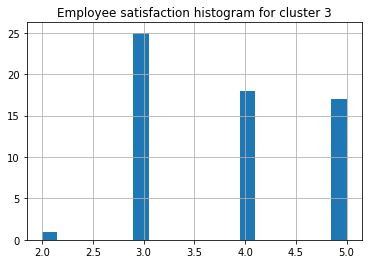

<Figure size 432x288 with 0 Axes>

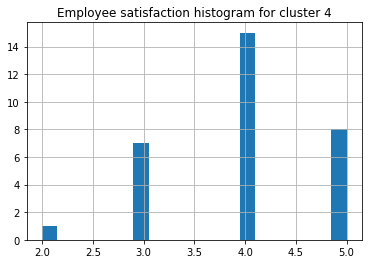

<Figure size 432x288 with 0 Axes>

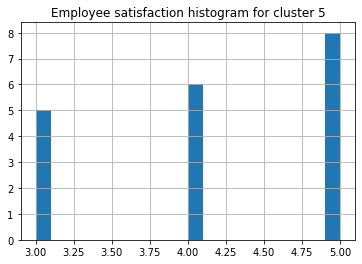

<Figure size 432x288 with 0 Axes>

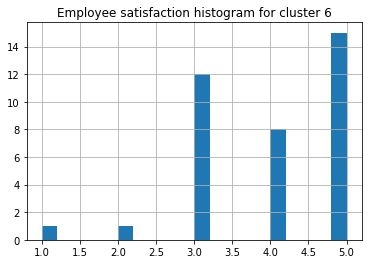

In [55]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["EmpSatisfaction"]].hist(bins=20)
    plt.title("Employee satisfaction histogram for cluster %d"%(cluster))
    plt.show()

In [56]:
high_satisfaction_employees=[]
low_satisfaction_employees=[]
high_satisfaction_employees_idx=[]
low_satisfaction_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    satisfaction=anomaly_data[anomaly_data["cluster"]==cluster][["EmpSatisfaction"]]
    mean_satisfaction=np.mean(satisfaction)
    sd_satisfaction=np.std(satisfaction)
    z=(satisfaction-mean_satisfaction)/sd_satisfaction
    z=z["EmpSatisfaction"]
    high_eng_survey_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_eng_survey_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_eng_survey_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_eng_survey_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])

high_satisfaction_employees=list(set(high_satisfaction_employees))
high_satisfaction_employees_idx=list(set(high_satisfaction_employees_idx))
low_satisfaction_employees=list(set(low_satisfaction_employees))
low_satisfaction_employees_idx=list(set(low_satisfaction_employees_idx))

print(high_satisfaction_employees)
print(high_satisfaction_employees_idx)
print(low_satisfaction_employees)
print(low_satisfaction_employees_idx)

[]
[]
[]
[]


In [57]:
anomaly_employees_high_satisfaction_data=data.iloc[high_satisfaction_employees_idx]
anomaly_employees_high_satisfaction_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


In [58]:
anomaly_employees_low_satisfaction_data=data.iloc[low_satisfaction_employees_idx]
anomaly_employees_low_satisfaction_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


array([[<AxesSubplot:title={'center':'SpecialProjectsCount'}>]],
      dtype=object)

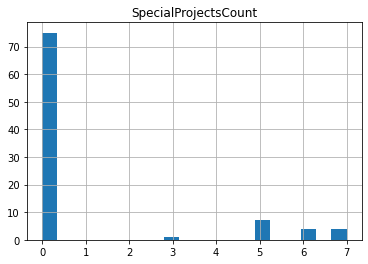

In [59]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on SpecialProjectsCount.
############################
anomaly_data[anomaly_data["cluster"]==0][["SpecialProjectsCount"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

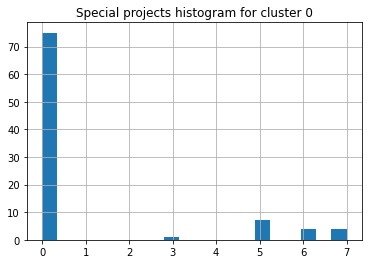

<Figure size 432x288 with 0 Axes>

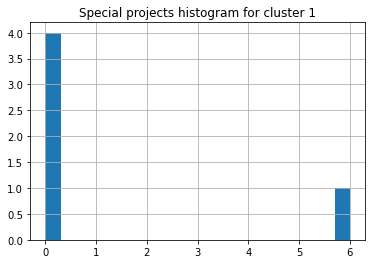

<Figure size 432x288 with 0 Axes>

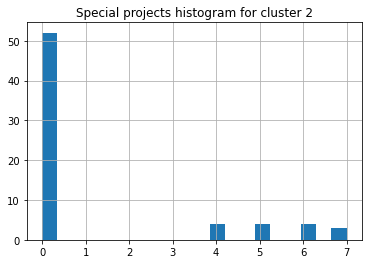

<Figure size 432x288 with 0 Axes>

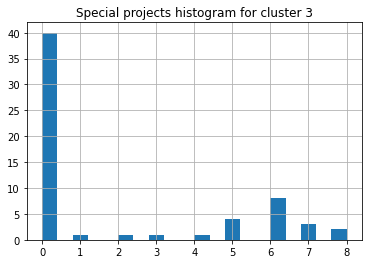

<Figure size 432x288 with 0 Axes>

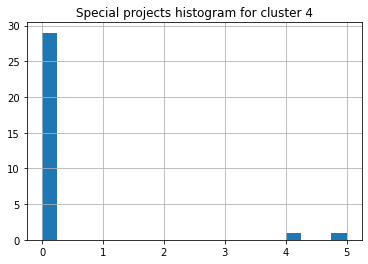

<Figure size 432x288 with 0 Axes>

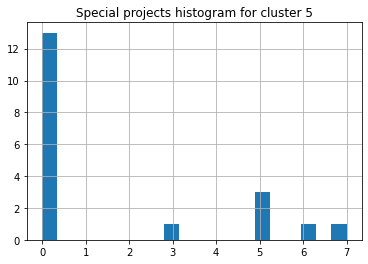

<Figure size 432x288 with 0 Axes>

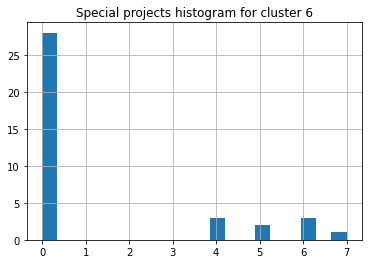

In [60]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["SpecialProjectsCount"]].hist(bins=20)
    plt.title("Special projects histogram for cluster %d"%(cluster))
    plt.show()

In [62]:
high_projects_employees=[]
low_projects_employees=[]
high_projects_employees_idx=[]
low_projects_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    projects=anomaly_data[anomaly_data["cluster"]==cluster][["SpecialProjectsCount"]]
    mean_projects=np.mean(projects)
    sd_projects=np.std(projects)
    z=(projects-mean_projects)/sd_projects
    z=z["SpecialProjectsCount"]
    high_projects_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_projects_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_projects_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_projects_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])

high_projects_employees=list(set(high_projects_employees))
high_projects_employees_idx=list(set(high_projects_employees_idx))
low_projects_employees=list(set(low_projects_employees))
low_projects_employees_idx=list(set(low_projects_employees_idx))

print(high_projects_employees)
print(high_projects_employees_idx)
print(low_projects_employees)
print(low_projects_employees_idx)

['Dietrich, Jenna  ', 'Biden, Lowan  M', 'Akinkuolie, Sarah', 'Daniele, Ann  ', 'Baczenski, Rachael  ', 'Clukey, Elijian', 'Estremera, Miguel', 'Bozzi, Charles']
[2, 72, 10, 51, 84, 21, 27, 61]
[]
[]


In [63]:
anomaly_employees_high_projects_data=data.iloc[high_projects_employees_idx]
anomaly_employees_high_projects_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster
2,"Akinkuolie, Sarah",64955,No,White,Kissy Sullivan,Fully Meets,3.02,3,0,0,3,0
72,"Dietrich, Jenna",59231,Yes,White,John Smith,PIP,2.30,1,0,2,17,6
10,"Baczenski, Rachael",54670,Yes,Black or African American,David Stanley,Fully Meets,4.20,4,0,0,12,0
51,"Clukey, Elijian",50373,No,White,Brannon Miller,Exceeds,4.10,4,0,0,5,0
84,"Estremera, Miguel",60340,No,White,Michael Albert,Needs Improvement,5.00,4,0,5,16,2
21,"Biden, Lowan M",64919,No,Asian,Ketsia Liebig,Fully Meets,4.20,3,0,0,2,6
27,"Bozzi, Charles",74312,No,Asian,Janet King,Fully Meets,3.39,3,0,0,14,2
61,"Daniele, Ann",85028,No,White,Peter Monroe,Fully Meets,3.10,5,8,0,19,3


In [64]:
anomaly_employees_low_projects_data=data.iloc[low_projects_employees_idx]
anomaly_employees_low_projects_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]
anomaly_employees_low_projects_data

,Employee_Name,EmpID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,Position,State,Zip,DOB,...,StateID,Age,SexID,MaritalDescID,CitizenDescID,HispanicLatinoID,RaceDescID,YearsHired,YearsTerminated,cluster


array([[<AxesSubplot:title={'center':'DaysLateLast30'}>]], dtype=object)

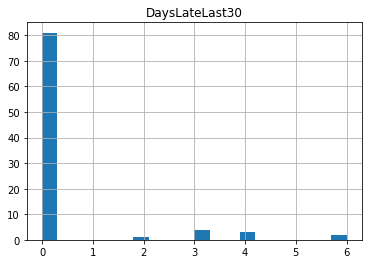

In [65]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on DaysLateLast30.
############################
anomaly_data[anomaly_data["cluster"]==0][["DaysLateLast30"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

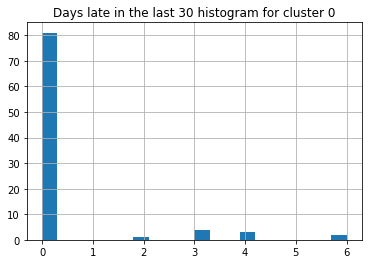

<Figure size 432x288 with 0 Axes>

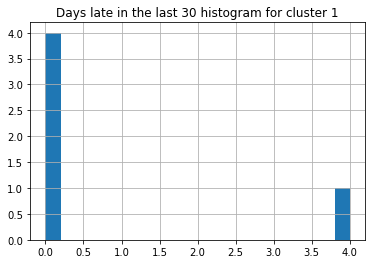

<Figure size 432x288 with 0 Axes>

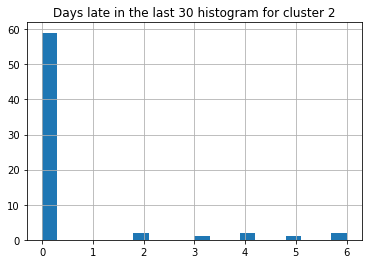

<Figure size 432x288 with 0 Axes>

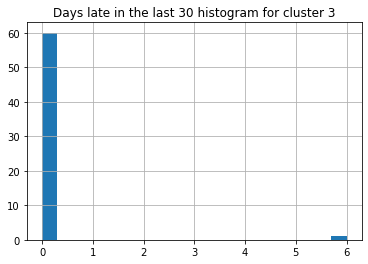

<Figure size 432x288 with 0 Axes>

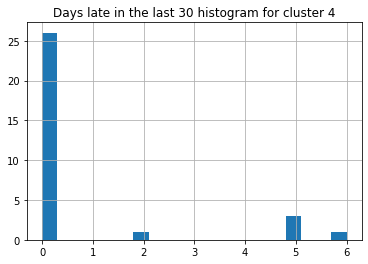

<Figure size 432x288 with 0 Axes>

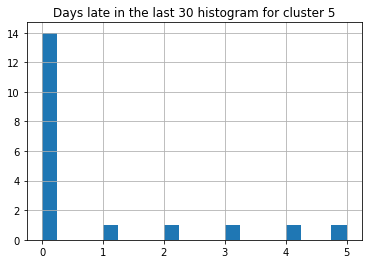

<Figure size 432x288 with 0 Axes>

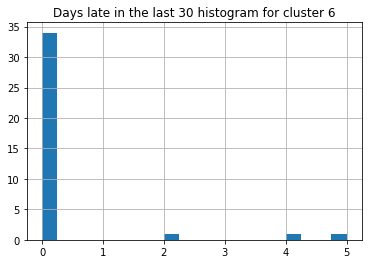

In [66]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["DaysLateLast30"]].hist(bins=20)
    plt.title("Days late in the last 30 histogram for cluster %d"%(cluster))
    plt.show()

In [67]:
high_days_late_employees=[]
low_days_late_employees=[]
high_days_late_employees_idx=[]
low_days_late_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    days_late=anomaly_data[anomaly_data["cluster"]==cluster][["DaysLateLast30"]]
    mean_days_late=np.mean(days_late)
    sd_days_late=np.std(days_late)
    z=(days_late-mean_days_late)/sd_days_late
    z=z["DaysLateLast30"]
    high_days_late_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_days_late_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_days_late_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_days_late_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])


high_days_late_employees=list(set(high_days_late_employees))
high_days_late_employees_idx=list(set(high_days_late_employees_idx))
low_days_late_employees=list(set(low_days_late_employees))
low_days_late_employees_idx=list(set(low_days_late_employees_idx))

print(high_days_late_employees)
print(high_days_late_employees_idx)
print(low_days_late_employees)
print(low_days_late_employees_idx)

['Buccheri, Joseph  ', 'Billis, Helen', 'Delarge, Alex', 'Chivukula, Enola', 'Beatrice, Courtney ', 'Alagbe,Trina', 'Clukey, Elijian', 'Bernstein, Sean', 'Costello, Frank', 'Barbara, Thomas', 'Chigurh, Anton', 'Bozzi, Charles', 'Booth, Frank']
[67, 3, 11, 45, 46, 17, 51, 20, 22, 25, 27, 30, 57]
[]
[]


In [68]:
anomaly_employees_high_days_late_data=data.iloc[high_days_late_employees_idx]
anomaly_employees_high_days_late_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster
67,"Delarge, Alex",61568,No,Two or more races,John Smith,PIP,1.93,3,0,6,5,2
3,"Alagbe,Trina",64991,No,White,Elijiah Gray,Fully Meets,4.84,5,0,0,15,0
11,"Barbara, Thomas",47211,Yes,Black or African American,Kissy Sullivan,Fully Meets,4.20,3,0,0,15,1
45,"Chigurh, Anton",66808,No,Black or African American,Lynn Daneault,Fully Meets,3.00,5,0,0,17,1
46,"Chivukula, Enola",64786,No,White,Amy Dunn,Fully Meets,4.30,4,0,0,3,4
17,"Beatrice, Courtney",59026,No,White,Elijiah Gray,Fully Meets,5.00,5,0,0,12,4
51,"Clukey, Elijian",50373,No,White,Brannon Miller,Exceeds,4.10,4,0,0,5,0
20,"Bernstein, Sean",51044,Yes,White,Amy Dunn,Fully Meets,5.00,3,0,0,13,2
22,"Billis, Helen",62910,No,White,Brannon Miller,Exceeds,5.00,3,0,0,19,3
25,"Booth, Frank",103613,No,Black or African American,Simon Roup,Fully Meets,3.50,5,7,0,2,5


In [69]:
anomaly_employees_low_days_late_data=data.iloc[low_days_late_employees_idx]
anomaly_employees_low_days_late_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


array([[<AxesSubplot:title={'center':'Absences'}>]], dtype=object)

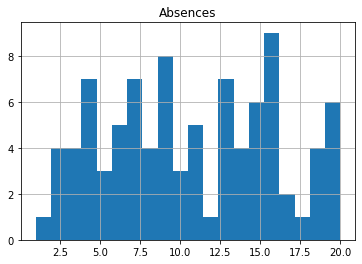

In [70]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on Absences.
############################
anomaly_data[anomaly_data["cluster"]==0][["Absences"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

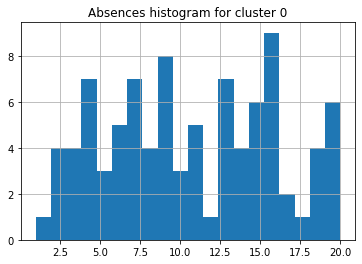

<Figure size 432x288 with 0 Axes>

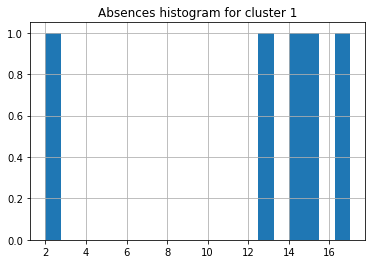

<Figure size 432x288 with 0 Axes>

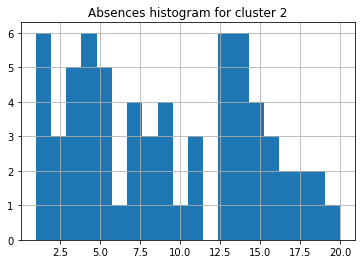

<Figure size 432x288 with 0 Axes>

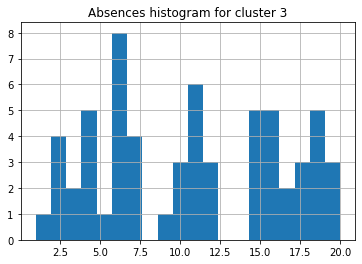

<Figure size 432x288 with 0 Axes>

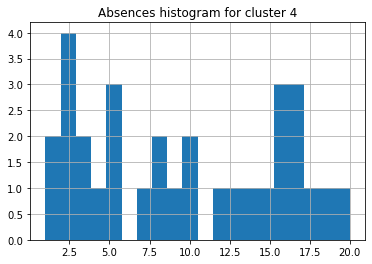

<Figure size 432x288 with 0 Axes>

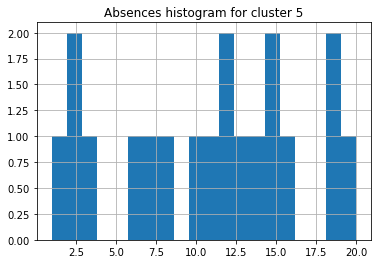

<Figure size 432x288 with 0 Axes>

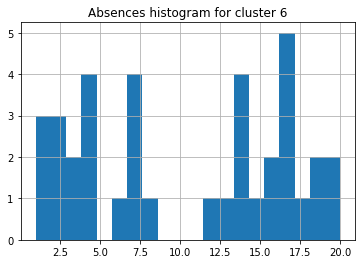

In [71]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["Absences"]].hist(bins=20)
    plt.title("Absences histogram for cluster %d"%(cluster))
    plt.show()

In [72]:
high_absences_employees=[]
low_absences_employees=[]
high_absences_employees_idx=[]
low_absences_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    absences=anomaly_data[anomaly_data["cluster"]==cluster][["Absences"]]
    mean_absences=np.mean(absences)
    sd_absences=np.std(absences)
    z=(absences-mean_absences)/sd_absences
    z=z["Absences"]
    high_absences_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_absences_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_absences_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_absences_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])

high_absences_employees=list(set(high_absences_employees))
high_absences_employees_idx=list(set(high_absences_employees_idx))
low_absences_employees=list(set(low_absences_employees))
low_absences_employees_idx=list(set(low_absences_employees_idx))

print(high_absences_employees)
print(high_absences_employees_idx)
print(low_absences_employees)
print(low_absences_employees_idx)

[]
[]
[]
[]


In [73]:
anomaly_employees_high_absences_data=data.iloc[high_absences_employees_idx]
anomaly_employees_high_absences_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


In [74]:
anomaly_employees_low_absences_data=data.iloc[low_absences_employees_idx]
anomaly_employees_low_absences_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


array([[<AxesSubplot:title={'center':'PerfScoreID'}>]], dtype=object)

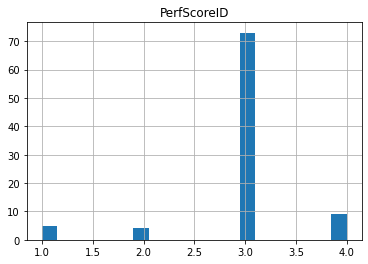

In [75]:
############################
#Find anomaly employees (with respect to their domegraphic cluster) based on PerfScoreID.
############################
anomaly_data[anomaly_data["cluster"]==0][["PerfScoreID"]].hist(bins=20)

<Figure size 432x288 with 0 Axes>

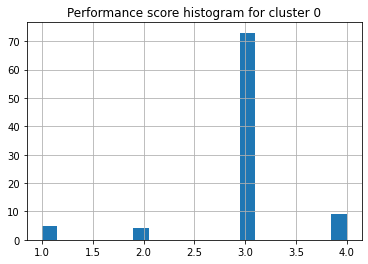

<Figure size 432x288 with 0 Axes>

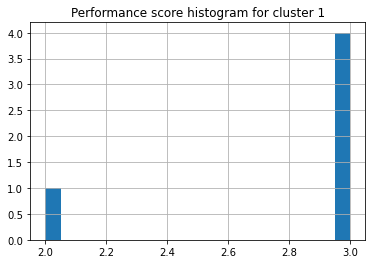

<Figure size 432x288 with 0 Axes>

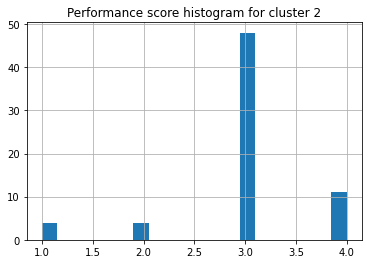

<Figure size 432x288 with 0 Axes>

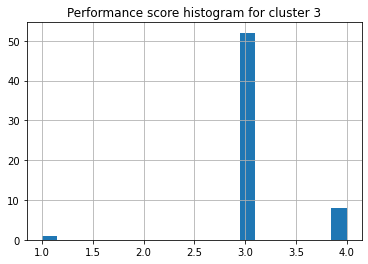

<Figure size 432x288 with 0 Axes>

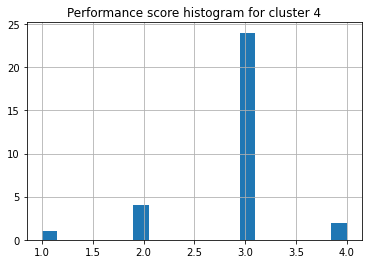

<Figure size 432x288 with 0 Axes>

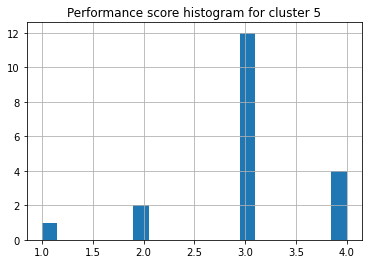

<Figure size 432x288 with 0 Axes>

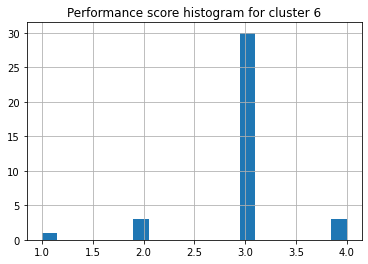

In [76]:
for cluster in all_clusters:
    plt.figure()
    anomaly_data[anomaly_data["cluster"]==cluster][["PerfScoreID"]].hist(bins=20)
    plt.title("Performance score histogram for cluster %d"%(cluster))
    plt.show()

In [77]:
high_performance_employees=[]
low_performance_employees=[]
high_performance_employees_idx=[]
low_performance_employees_idx=[]
upper_cutoff=2.5
lower_cutoff=-2.5
for cluster in all_clusters:
    performances=anomaly_data[anomaly_data["cluster"]==cluster][["PerfScoreID"]]
    mean_performances=np.mean(performances)
    sd_performances=np.std(performances)
    z=(performances-mean_performances)/sd_performances
    z=z["PerfScoreID"]
    high_performance_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x>upper_cutoff])
    high_performance_employees_idx.extend([i for i,x in enumerate(z) if x>upper_cutoff])
    low_performance_employees.extend([anomaly_data["Employee_Name"].iloc[i] for i,x in enumerate(z) if x<lower_cutoff])
    low_performance_employees_idx.extend([i for i,x in enumerate(z) if x<lower_cutoff])

high_performance_employees=list(set(high_performance_employees))
high_performance_employees_idx=list(set(high_performance_employees_idx))
low_performance_employees=list(set(low_performance_employees))
low_performance_employees_idx=list(set(low_performance_employees_idx))

print(high_performance_employees)
print(high_performance_employees_idx)
print(low_performance_employees)
print(low_performance_employees_idx)

[]
[]
['Buccheri, Joseph  ', 'Billis, Helen', 'Brill, Donna', 'Dougall, Eric', 'Beatrice, Courtney ', 'Boutwell, Bonalyn', 'Clukey, Elijian', 'Bernstein, Sean', 'Bates, Norman', 'Chigurh, Anton', 'Bacong, Alejandro ']
[9, 76, 45, 15, 17, 51, 20, 22, 26, 28, 30]


In [78]:
anomaly_employees_high_performance_data=data.iloc[high_performance_employees_idx]
anomaly_employees_high_performance_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster


In [79]:
anomaly_employees_low_performance_data=data.iloc[low_performance_employees_idx]
anomaly_employees_low_performance_data[['Employee_Name','Salary','HispanicLatino','RaceDesc','ManagerName','PerformanceScore',
                        'EngagementSurvey', 'EmpSatisfaction',"SpecialProjectsCount","DaysLateLast30","Absences","cluster"]]

,Employee_Name,Salary,HispanicLatino,RaceDesc,ManagerName,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,cluster
9,"Bacong, Alejandro",50178,No,White,Peter Monroe,Fully Meets,5.00,5,6,0,16,0
76,"Dougall, Eric",138888,No,Black or African American,Jennifer Zamora,Exceeds,4.30,5,5,0,4,2
45,"Chigurh, Anton",66808,No,Black or African American,Lynn Daneault,Fully Meets,3.00,5,0,0,17,1
15,"Bates, Norman",57834,No,White,Kelley Spirea,Fully Meets,5.00,4,0,0,20,0
17,"Beatrice, Courtney",59026,No,White,Elijiah Gray,Fully Meets,5.00,5,0,0,12,4
51,"Clukey, Elijian",50373,No,White,Brannon Miller,Exceeds,4.10,4,0,0,5,0
20,"Bernstein, Sean",51044,Yes,White,Amy Dunn,Fully Meets,5.00,3,0,0,13,2
22,"Billis, Helen",62910,No,White,Brannon Miller,Exceeds,5.00,3,0,0,19,3
26,"Boutwell, Bonalyn",106367,No,Black or African American,Brandon R. LeBlanc,Fully Meets,5.00,4,3,0,4,3
28,"Brill, Donna",53492,No,White,David Stanley,Fully Meets,3.35,4,0,0,6,3
